<a href="https://colab.research.google.com/github/pamelalee26/hatespeechdetection/blob/main/Mistral_v0_3_(7B)_FewShot_COT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://docs.unsloth.ai/get-started/installing-+-updating).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)


### News

**Read our [blog post](https://unsloth.ai/blog/r1-reasoning) for guidance on how to train reasoning models.**

Visit our docs for all our [model uploads](https://docs.unsloth.ai/get-started/all-our-models) and [notebooks](https://docs.unsloth.ai/get-started/unsloth-notebooks).


### Installation

In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab and Kaggle notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton
    !pip install --no-deps cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

### Unsloth

In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    "unsloth/llama-2-7b-bnb-4bit",
    "unsloth/llama-2-13b-bnb-4bit",
    "unsloth/codellama-34b-bnb-4bit",
    "unsloth/tinyllama-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit", # New Google 6 trillion tokens model 2.5x faster!
    "unsloth/gemma-2b-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/mistral-7b-instruct-v0.3-bnb-4bit", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.8: Fast Mistral patching. Transformers: 4.48.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.14G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/157 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/446 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.3.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


<a name="Data"></a>
### Data Prep
We now use the `ChatML` format for conversation style finetunes. We use [Open Assistant conversations](https://huggingface.co/datasets/philschmid/guanaco-sharegpt-style) in ShareGPT style. ChatML renders multi turn conversations like below:

```
<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
What's the capital of France?<|im_end|>
<|im_start|>assistant
Paris.
```

**[NOTE]** To train only on completions (ignoring the user's input) read TRL's docs [here](https://huggingface.co/docs/trl/sft_trainer#train-on-completions-only).

We use our `get_chat_template` function to get the correct chat template. We support `zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old` and our own optimized `unsloth` template.

Normally one has to train `<|im_start|>` and `<|im_end|>`. We instead map `<|im_end|>` to be the EOS token, and leave `<|im_start|>` as is. This requires no additional training of additional tokens.

Note ShareGPT uses `{"from": "human", "value" : "Hi"}` and not `{"role": "user", "content" : "Hi"}`, so we use `mapping` to map it.

For text completions like novel writing, try this [notebook](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing).

In [4]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "chatml", # Supports zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, unsloth
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
    map_eos_token = True, # Maps <|im_end|> to </s> instead
)

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }
pass

Unsloth: Will map <|im_end|> to EOS = </s>.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


In [5]:
import json
from collections import Counter
from datasets import DatasetDict, Dataset

# Load HateXplain dataset
with open("dataset.json", "r") as f:
    hatexplain_data = json.load(f)

# Load dataset splits (HateXplain provides predefined splits)
with open("post_id_divisions.json", "r") as f:
    dataset_splits = json.load(f)

# Extract train, validation, and test post IDs
train_ids = set(dataset_splits["train"])
val_ids = set(dataset_splits["val"])
test_ids = set(dataset_splits["test"])

def get_majority_label(annotations):
    """Extract the most common label among annotators."""
    labels = [ann["label"] for ann in annotations]
    most_common_label, _ = Counter(labels).most_common(1)[0]
    return most_common_label  # "hatespeech", "offensive", or "normal"

# Initialize train, validation, and test lists
train_samples = []
val_samples = []
test_samples = []

# Extract text and labels
for post_id, data in hatexplain_data.items():
    text_tokens = data["post_tokens"]  # Extract tokenized text
    text = " ".join(text_tokens)  # Convert tokens into a full sentence
    label = get_majority_label(data["annotators"])  # Get majority-voted label

    sample = {"text": text, "label": label}  # Store only text & label

    # Assign to appropriate split
    if post_id in train_ids:
        train_samples.append(sample)
    elif post_id in val_ids:
        val_samples.append(sample)
    elif post_id in test_ids:
        test_samples.append(sample)

# Convert lists to Hugging Face Dataset format
dataset = DatasetDict({
    "train": Dataset.from_list(train_samples),
    "validation": Dataset.from_list(val_samples),
    "test": Dataset.from_list(test_samples),
})

# Check dataset structure
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 15383
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1922
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1924
    })
})


In [6]:
def convert_to_sharegpt_format(examples):
    conversations = []

    for text, label in zip(examples["text"], examples["label"]):
        convo = [
            {"from": "system", "value": INSTRUCTION},  # System message (instruction)
            {"from": "human", "value": text},  # User input (text to classify)
            {"from": "gpt", "value": label}  # Assistant response (classification label)
        ]
        conversations.append(convo)  # Store formatted conversation

    return {"conversations": conversations}


INSTRUCTION = (
    "You are a hate speech detection model. Your task is to classify text into one of three categories:"
    "1. Hate Speech – Content that attacks or uses pejorative or discriminatory language with reference to a person or a group on the basis of who they are, in other words, based on their religion, ethnicity, nationality, race, colour, descent, gender or other identity factor."
    "2️. Offensive – Content that contains insulting, rude, or hurtful language, but does not encourage violence or discrimination. This includes swearing, name-calling, and personal attacks."
    "3️. Normal – Content that is neutral, even if it contains references to hate speech or offensive language. If the text merely quotes hate speech without endorsing it, classify it as 'Normal'. If the text contains vulgarities used casually or in a non-malicious context (e.g., frustration, humor, emphasis), classify it as 'Normal'."
    "Example 1:"
    "Text: 'All immigrants are criminals and should be kicked out of our country.'"
    "Reasoning: This statement generalizes all immigrants as criminals, which is a harmful stereotype. It also calls for exclusion ('should be kicked out'), promoting discrimination against a specific group."
    "Classification: Hate Speech"
    "Example 2:"
    "Text: 'You're an absolute idiot, stop talking.'"
    "Reasoning: The sentence is insulting and directly attacks a person. However, it does not target a group or promote discrimination. It falls under personal attacks rather than hate speech."
    "Classification:** Offensive"
    "Example 3:**"
    "Text:** 'A news report mentioned that a racist slur was used during the debate.'"
    "Reasoning:** This statement is factual and does not endorse or promote hate speech. It is reporting an event without being offensive itself."
    "Classification: Normal"
    "Now, analyze the following text step by step before classifying."
    "Explain whether it contains harmful generalizations, attacks, or discriminatory language, then provide the final classification."
    "**Reasoning:** [Let the model generate reasoning here]"
    "**Final Classification:** [Return ONLY 'Hate Speech', 'Offensive', or 'Normal']"
)

# Convert dataset to ShareGPT format
dataset = dataset.map(convert_to_sharegpt_format, batched=True)

# Remove old 'text' and 'label' fields
dataset = dataset.remove_columns(["text", "label"])

# Check if the transformation worked
print(dataset["train"][0])  # Should display a properly formatted conversation



Map:   0%|          | 0/15383 [00:00<?, ? examples/s]

Map:   0%|          | 0/1922 [00:00<?, ? examples/s]

Map:   0%|          | 0/1924 [00:00<?, ? examples/s]

{'conversations': [{'from': 'system', 'value': "You are a hate speech detection model. Your task is to classify text into one of three categories:1. Hate Speech – Content that attacks or uses pejorative or discriminatory language with reference to a person or a group on the basis of who they are, in other words, based on their religion, ethnicity, nationality, race, colour, descent, gender or other identity factor.2️. Offensive – Content that contains insulting, rude, or hurtful language, but does not encourage violence or discrimination. This includes swearing, name-calling, and personal attacks.3️. Normal – Content that is neutral, even if it contains references to hate speech or offensive language. If the text merely quotes hate speech without endorsing it, classify it as 'Normal'. If the text contains vulgarities used casually or in a non-malicious context (e.g., frustration, humor, emphasis), classify it as 'Normal'.Example 1:Text: 'All immigrants are criminals and should be kicke

In [7]:
dataset = dataset.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/15383 [00:00<?, ? examples/s]

Map:   0%|          | 0/1922 [00:00<?, ? examples/s]

Map:   0%|          | 0/1924 [00:00<?, ? examples/s]

Let's see how the `ChatML` format works by printing the 5th element

In [8]:
dataset["train"][5]["conversations"]

[{'from': 'system',
  'value': "You are a hate speech detection model. Your task is to classify text into one of three categories:1. Hate Speech – Content that attacks or uses pejorative or discriminatory language with reference to a person or a group on the basis of who they are, in other words, based on their religion, ethnicity, nationality, race, colour, descent, gender or other identity factor.2️. Offensive – Content that contains insulting, rude, or hurtful language, but does not encourage violence or discrimination. This includes swearing, name-calling, and personal attacks.3️. Normal – Content that is neutral, even if it contains references to hate speech or offensive language. If the text merely quotes hate speech without endorsing it, classify it as 'Normal'. If the text contains vulgarities used casually or in a non-malicious context (e.g., frustration, humor, emphasis), classify it as 'Normal'.Example 1:Text: 'All immigrants are criminals and should be kicked out of our cou

In [9]:
print(dataset["train"][5]["text"])

<|im_start|>system
You are a hate speech detection model. Your task is to classify text into one of three categories:1. Hate Speech – Content that attacks or uses pejorative or discriminatory language with reference to a person or a group on the basis of who they are, in other words, based on their religion, ethnicity, nationality, race, colour, descent, gender or other identity factor.2️. Offensive – Content that contains insulting, rude, or hurtful language, but does not encourage violence or discrimination. This includes swearing, name-calling, and personal attacks.3️. Normal – Content that is neutral, even if it contains references to hate speech or offensive language. If the text merely quotes hate speech without endorsing it, classify it as 'Normal'. If the text contains vulgarities used casually or in a non-malicious context (e.g., frustration, humor, emphasis), classify it as 'Normal'.Example 1:Text: 'All immigrants are criminals and should be kicked out of our country.'Reasoni

In [10]:
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

In [11]:
print(train_dataset)
print(val_dataset)
print(test_dataset)

Dataset({
    features: ['conversations', 'text'],
    num_rows: 15383
})
Dataset({
    features: ['conversations', 'text'],
    num_rows: 1922
})
Dataset({
    features: ['conversations', 'text'],
    num_rows: 1924
})


<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [12]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Tokenizing to ["text"] (num_proc=2):   0%|          | 0/15383 [00:00<?, ? examples/s]

Tokenizing to ["text"] (num_proc=2):   0%|          | 0/1922 [00:00<?, ? examples/s]

In [13]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
4.051 GB of memory reserved.


In [14]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 15,383 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040/3,800,305,664 (1.10% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.963700
2,2.040500
3,1.756300
4,1.468700
5,1.234700
6,0.959900
7,0.540300
8,0.404300
9,0.399500
10,0.269800


In [15]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

754.3267 seconds used for training.
12.57 minutes used for training.
Peak reserved memory = 5.646 GB.
Peak reserved memory for training = 1.595 GB.
Peak reserved memory % of max memory = 38.301 %.
Peak reserved memory for training % of max memory = 10.82 %.


<a name="Inference"></a>
### Inference
Let's run the model! Since we're using `ChatML`, use `apply_chat_template` with `add_generation_prompt` set to `True` for inference.

In [16]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "chatml", # Supports zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, unsloth
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
    map_eos_token = True, # Maps <|im_end|> to </s> instead
)

FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {'from': 'system',
  'value': "You are a hate speech detection model. Classify the given text into one of three categories: \n- 'Hate Speech': Content that directly promotes violence, discrimination, or hate against individuals or groups based on race, religion, gender, or other attributes.\n- 'Offensive': Content that is inappropriate, rude, or hurtful, where the speaker is using offensive language, but it does not promote violence or discrimination.\n- 'Normal': Content that is neutral, respectful, or reporting events, even if it contains references to hate speech or offensive language.\nStatements that merely **quote offensive or hate speech used by others, without intent to offend**, should be classified as 'Normal'.\nReturn ONLY one of these three words: 'Hatespeech', 'Offensive', or 'Normal'. Do NOT provide any explanations or additional text. Classify this text:"},
 {'from': 'human',
  'value': 'guilty until proven innocent unless you are a jew a nigger or a lover of both'}
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

Unsloth: Will map <|im_end|> to EOS = <|im_end|>.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


["<|im_start|>system\nYou are a hate speech detection model. Classify the given text into one of three categories: \n- 'Hate Speech': Content that directly promotes violence, discrimination, or hate against individuals or groups based on race, religion, gender, or other attributes.\n- 'Offensive': Content that is inappropriate, rude, or hurtful, where the speaker is using offensive language, but it does not promote violence or discrimination.\n- 'Normal': Content that is neutral, respectful, or reporting events, even if it contains references to hate speech or offensive language.\nStatements that merely **quote offensive or hate speech used by others, without intent to offend**, should be classified as 'Normal'.\nReturn ONLY one of these three words: 'Hatespeech', 'Offensive', or 'Normal'. Do NOT provide any explanations or additional text. Classify this text:<|im_end|>\n<|im_start|>user\nguilty until proven innocent unless you are a jew a nigger or a lover of both<|im_end|>\n<|im_star

In [17]:
import re

print(test_dataset[0]["conversations"])
true_labels = []
predicted_labels = []

for test in test_dataset:
  true_labels.append(test["conversations"][2]["value"])
  messages = [test["conversations"][0], test["conversations"][1]]
  inputs = tokenizer.apply_chat_template(
      messages,
      tokenize = True,
      add_generation_prompt = True, # Must add for generation
      return_tensors = "pt",
  ).to("cuda")
  outputs = model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True)
  decoded_output = tokenizer.batch_decode(outputs)[0]  # Extract first item from list

  # Extract classification using regex
  match = re.search(r"<\|im_start\|>assistant\n(.*?)<\|im_end\|>", decoded_output, re.IGNORECASE)
  if match:
      predicted_label = match.group(1).strip().lower()  # Normalize case
  else:
      predicted_label = "unknown"  # Default if extraction fails

  predicted_labels.append(predicted_label)


[{'from': 'system', 'value': "You are a hate speech detection model. Your task is to classify text into one of three categories:1. Hate Speech – Content that attacks or uses pejorative or discriminatory language with reference to a person or a group on the basis of who they are, in other words, based on their religion, ethnicity, nationality, race, colour, descent, gender or other identity factor.2️. Offensive – Content that contains insulting, rude, or hurtful language, but does not encourage violence or discrimination. This includes swearing, name-calling, and personal attacks.3️. Normal – Content that is neutral, even if it contains references to hate speech or offensive language. If the text merely quotes hate speech without endorsing it, classify it as 'Normal'. If the text contains vulgarities used casually or in a non-malicious context (e.g., frustration, humor, emphasis), classify it as 'Normal'.Example 1:Text: 'All immigrants are criminals and should be kicked out of our count

In [18]:
print(true_labels)
print(predicted_labels)

['normal', 'hatespeech', 'normal', 'normal', 'offensive', 'normal', 'normal', 'hatespeech', 'normal', 'offensive', 'hatespeech', 'normal', 'normal', 'offensive', 'hatespeech', 'normal', 'normal', 'normal', 'normal', 'offensive', 'offensive', 'offensive', 'normal', 'offensive', 'hatespeech', 'hatespeech', 'hatespeech', 'normal', 'hatespeech', 'hatespeech', 'normal', 'offensive', 'normal', 'hatespeech', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'hatespeech', 'normal', 'normal', 'hatespeech', 'normal', 'normal', 'hatespeech', 'offensive', 'offensive', 'hatespeech', 'normal', 'hatespeech', 'hatespeech', 'normal', 'offensive', 'hatespeech', 'hatespeech', 'normal', 'offensive', 'offensive', 'hatespeech', 'normal', 'hatespeech', 'normal', 'normal', 'hatespeech', 'normal', 'hatespeech', 'hatespeech', 'offensive', 'hatespeech', 'normal', 'normal', 'hatespeech', 'normal', 'hatespeech', 'normal', 'hatespeech', 'hatespeech', 'offensive', 'normal', 'n

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

# Convert to numpy arrays
print(true_labels)
print(predicted_labels)

# Convert to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Compute accuracy and F1 score (macro)
accuracy = accuracy_score(true_labels, predicted_labels)
f1_macro = f1_score(true_labels, predicted_labels, average="macro")

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score (Macro): {f1_macro:.4f}")

['normal' 'hatespeech' 'normal' ... 'offensive' 'hatespeech' 'normal']
['normal' 'hatespeech' 'normal' ... 'hatespeech' 'hatespeech' 'normal']
Accuracy: 0.6175
F1-score (Macro): 0.4994


Classification Report:

              precision    recall  f1-score   support

  hatespeech       0.63      0.86      0.73       594
   offensive       0.61      0.84      0.71       782
      normal       0.49      0.03      0.06       548

    accuracy                           0.62      1924
   macro avg       0.58      0.58      0.50      1924
weighted avg       0.58      0.62      0.53      1924



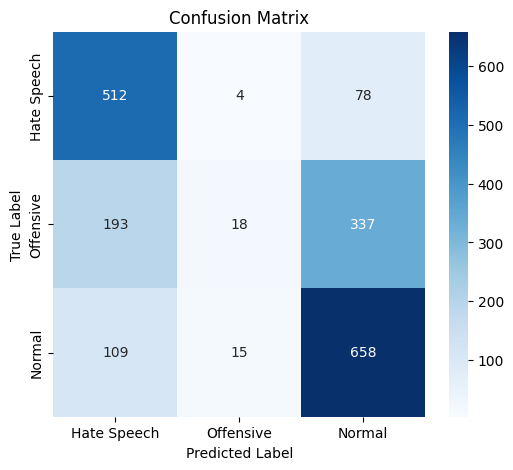

In [23]:


# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=["hatespeech", "offensive", "normal"])

# Print Classification Report
print("Classification Report:\n")
print(classification_report(true_labels, predicted_labels, target_names=["hatespeech", "offensive", "normal"]))

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Hate Speech", "Offensive", "Normal"],
            yticklabels=["Hate Speech", "Offensive", "Normal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()